# 옵저버 설계

2차 시스템에서는 L을 잘 정의하여 오차함수의 폴이 좌반 평면에 존재하도록 하는 것이 주 관심사이다. 

inverted pendulum은 4차 시스템이다. 기본은 역시 L을 잘 설계하여 폴이 모두 좌반 평면에 존재하도록 하는 것인데, Routh - Hurwitz 판별법에서 루스 배열의 모든 값이 양수여야 하는 이유도 그에 따른 것이다.

따라서 $det(sI - A +LC) = 0$의 해의 실수부가 모두 0보다 작게하는 L을 선택하면 된다.

원하는 응답 튿성을 갖도록 구체적인 특성방정식과 갖게 만드는 L을 찾아도 좋다.

이렇게 적절한 응답특성을 갖도록 폴을 직접 선택하여 L을 설계하는 방식을 pole place method 방식이라고 한다.


또 다른 L설계 방식으로 최적화 이론이 적용된 **LQR(Linear Quadratic Regulation)** 방법이 있다. 

### 3.1.1 LQR 
비용 함수(Cost Function)를 최소화하도록 \( L \) 을 결정하는 것이 목표이다.

$$
J = \int_0^\infty (e_x^T Q e_x + u^T R u) dt
$$

여기서:
- $Q$ : 상태 추정 오차를 최소화하는 가중치 행렬
- $R$ : 옵저버의 입력 감도를 조절하는 가중치 행렬

LQR 옵저버 게인 \( L \) 은 다음 **리카티 방정식 (Riccati Equation)** 을 풀어 계산된다.

$$
A^T P + P A - P C^T R^{-1} C P + Q = 0
$$

그 후 옵저버 게인은:

$$
L = P C^T R^{-1}
$$

이와 같이 최적화된 옵저버 게인 \( L \) 을 얻을 수 있다.

---

#### \( R \) 값의 의미 및 옵저버의 입력 민감성
**\( R \) 값이 작은 경우**
- 옵저버가 입력 \( u \) 에 **민감하게 반응**한다.
- 빠른 응답을 가지지만, **센서 노이즈에도 민감**하여 불안정할 수 있다.

**\( R \) 값이 큰 경우**
- 옵저버가 입력 \( u \) 를 덜 신뢰하고, **출력 \( y \) 를 더 신뢰**한다.
- 하지만, **응답 속도가 너무 느려질 수 있음**.
  
#### 옵저버가 입력 U에 대해 민감하다의 의미
- 작은 입력 변화에도(노이즈 등) $\hat{x}$이 매우 빠르게 민감하게 변화함.
- 예를들어 노이즈가 포함된 입력에 대한 상태, 즉 실제 상태를 X1, 노이즈가 포함되지 않은 입력에 대한 상태를 X2라고 하자. 옵저버 즉 $\hat{x}$은 노이즈가 포함되지 않은 입력으로 계산되기에 X2에 수렴할테니 $\hat{x}$이 너무 빠르게 x2에 수렴하면 x1과의 오차가 누적된다. 따라서 u의 작은 변화에 대해 $\hat{x}$이 원래의 특성을 유지하며 적당한 속도로 수렴하도록 만들면 보다 강인한 옵저버를 만들 수 있다.

#### \( R \) 값을 적절하게 조절하는 중요성
- \( R \) 값을 너무 작게 하면 **빠르지만 노이즈에 취약**한 옵저버가 됨.
- \( R \) 값을 너무 크게 하면 **안정적이지만 반응이 둔한** 옵저버가 됨.
- 따라서 **실제 시스템의 요구 사항에 따라 \( R \) 값을 적절하게 조절하는 것이 중요**하다

### 3.1.2 inverted pendulum 시스템의 옵저버 설계 예제
Q와 R 값(MATRIX)은 임의로 설정한 채로 LQR 방식을 적용하여 옵저버를 시뮬레이션 하는 코드와 폴배치법을 이용한 코드 두 가지를 제시한다.

폴배치법의 경우 시뮬레이션 편의상 노이즈는 포함시키지 않았다.

펜듈럼을 정상 상태로 만드는 제어기 (LQR 방식 적용)함께 시뮬레이션 되도록 설계하였다.

컨트롤러의 리카티 방정식과 옵저버의 리카티 방정식은 분리하여 계산해 주어야 한다.

y에 노이즈 추가 코드
```python
+ np.random.normal(0, 0.01, (1, 1))
```

폴 배치법 이용

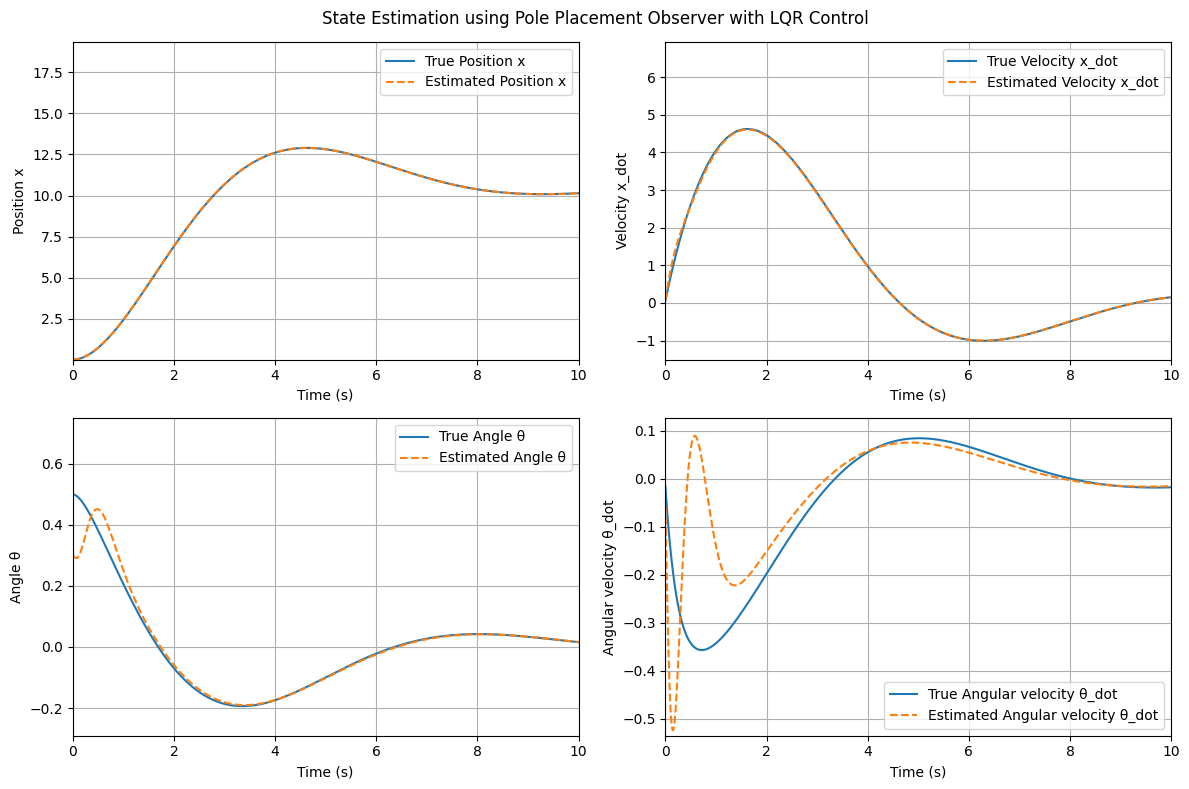

In [2]:
import numpy as np
import scipy.linalg
import scipy.signal
import matplotlib.pyplot as plt

# 시스템 매트릭스 정의
A = np.array([[0, 1, 0, 0],
              [0, 0, -9.8, 0],
              [0, 0, 0, 1],
              [0, 0, 19.6, 0]])

B = np.array([[0], [1], [0], [-1]])

C = np.array([[1, 0, 0, 0]])  # 위치 측정

# 🔹 LQR 게인 계산 (제어기 용)
Q = 10 * np.eye(4)
R = np.array([[1]])  

# 🔹 리카티 방정식 풀이 (Scipy 사용)
P = scipy.linalg.solve_continuous_are(A, B, Q, R)

# 상태 피드백 제어기 게인 K 계산
K = np.linalg.inv(R + B.T @ P @ B) @ B.T @ P @ A  

# 🔹 옵저버 게인 L을 폴 배치 방식으로 설계
observer_poles = np.array([-5+3j,-5-3j,-7,-8])  # 옵저버 폴 선택
L = scipy.signal.place_poles(A.T, C.T, observer_poles).gain_matrix.T

# 룬지-쿠타 4차 (RK4) 적용
def rk4_step(f, x, u, dt, y=None):
    if y is not None:  
        k1 = f(x, u, y)
        k2 = f(x + dt * k1 / 2, u, y)
        k3 = f(x + dt * k2 / 2, u, y)
        k4 = f(x + dt * k3, u, y)
    else:
        k1 = f(x, u)
        k2 = f(x + dt * k1 / 2, u)
        k3 = f(x + dt * k2 / 2, u)
        k4 = f(x + dt * k3, u)

    return x + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)

# 시스템 동역학 정의 (제어기 포함)
def system_dynamics(x, u):
    return A @ x + B @ u

# 옵저버 동역학 정의
def observer_dynamics(x_hat, u, y):
    return A @ x_hat + B @ u + L @ (y - C @ x_hat)

# 시뮬레이션 설정
dt = 0.01
T = 10
N = int(T / dt)

# 🔹 초기 상태 설정 (더 현실적인 값)
x = np.array([[0], [0], [0.5], [0]])  
x_hat = np.array([[0], [0], [0.3], [0]])  # 옵저버 초기값

# 상태 기록용 배열
x_history = []
x_hat_history = []
u_history = []

# 시뮬레이션 루프
for i in range(N):
    u = -K @ x  

    x = rk4_step(system_dynamics, x, u, dt)

    y = C @ x

    x_hat = rk4_step(observer_dynamics, x_hat, u, dt, y=y)

    x_history.append(x.flatten())
    x_hat_history.append(x_hat.flatten())
    u_history.append(u.flatten())

# NumPy 배열 변환
x_history = np.array(x_history)
x_hat_history = np.array(x_hat_history)
u_history = np.array(u_history)

# 🔹 그래프 개선: 더 넓은 범위에서 표시
plt.figure(figsize=(12, 8))

labels = ["Position x", "Velocity x_dot", "Angle θ", "Angular velocity θ_dot"]
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(np.linspace(0, T, len(x_history)), x_history[:, i], label="True " + labels[i])
    plt.plot(np.linspace(0, T, len(x_hat_history)), x_hat_history[:, i], '--', label="Estimated " + labels[i])
    plt.legend()
    plt.xlabel("Time (s)")
    plt.ylabel(labels[i])
    plt.grid()

    plt.xlim([0, T])  
    plt.ylim([x_history[:, i].min() * 1.5, x_history[:, i].max() * 1.5])  

plt.suptitle("State Estimation using Pole Placement Observer with LQR Control")
plt.tight_layout()
plt.show()

LQR 방식 적용(with noise)

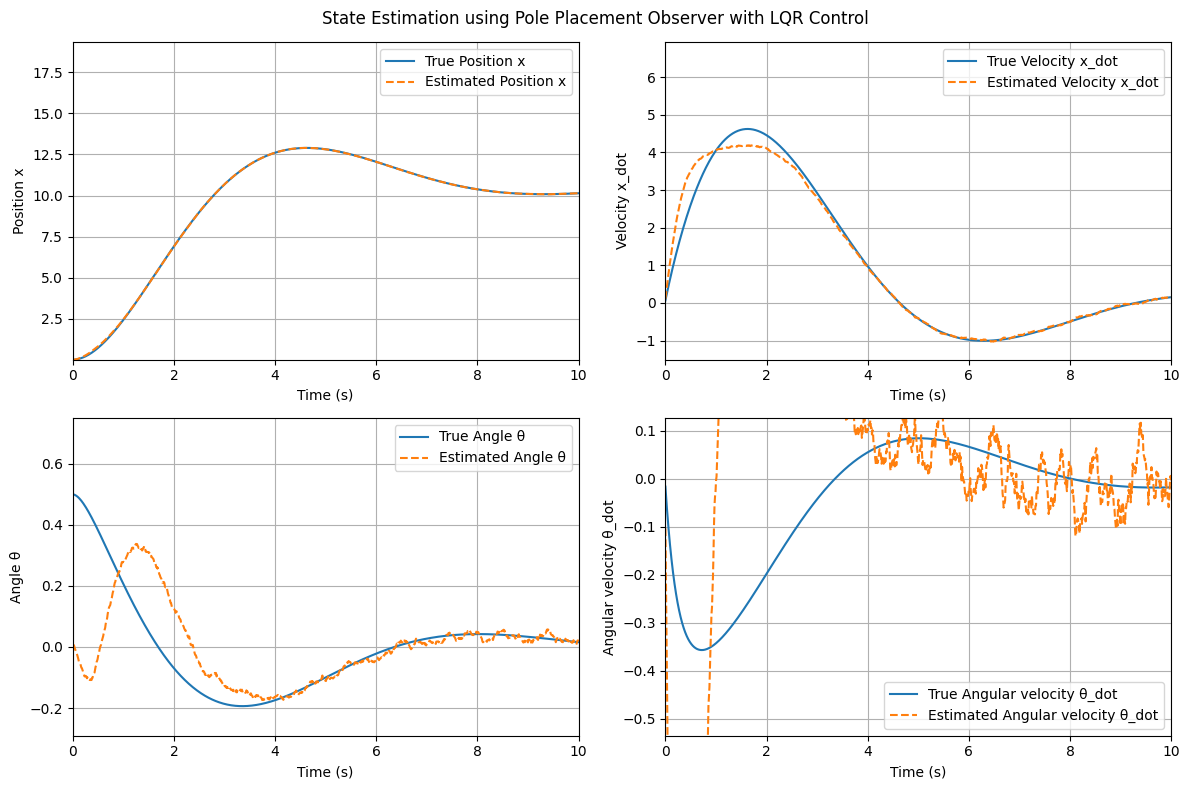

In [3]:
import numpy as np
import scipy.linalg
import scipy.signal
import matplotlib.pyplot as plt

# 시스템 매트릭스 정의
A = np.array([[0, 1, 0, 0],
              [0, 0, -9.8, 0],
              [0, 0, 0, 1],
              [0, 0, 19.6, 0]])

B = np.array([[0], [1], [0], [-1]])

C = np.array([[1, 0, 0, 0]])  # 위치 측정

# 🔹 컨트롤러 최적화 (LQR)
Q_control = 10 * np.eye(4)  
R_control = np.array([[1]])

P_control = scipy.linalg.solve_continuous_are(A, B, Q_control, R_control)
K = np.linalg.inv(R_control + B.T @ P_control @ B) @ B.T @ P_control @ A  

# 🔹 옵저버 최적화 (Kalman Filter 방식)
Q_observer = np.diag([1, 1, 200, 500])  
R_observer = np.array([[10]])  

P_observer = scipy.linalg.solve_continuous_are(A.T, C.T, Q_observer, R_observer)
L = P_observer @ C.T @ np.linalg.inv(R_observer)

# 룬지-쿠타 4차 (RK4) 적용
def rk4_step(f, x, u, dt, y=None):
    if y is not None:  
        k1 = f(x, u, y)
        k2 = f(x + dt * k1 / 2, u, y)
        k3 = f(x + dt * k2 / 2, u, y)
        k4 = f(x + dt * k3, u, y)
    else:
        k1 = f(x, u)
        k2 = f(x + dt * k1 / 2, u)
        k3 = f(x + dt * k2 / 2, u)
        k4 = f(x + dt * k3, u)

    return x + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)

# 시스템 동역학 정의 (제어기 포함)
def system_dynamics(x, u):
    return A @ x + B @ u

# 옵저버 동역학 정의
def observer_dynamics(x_hat, u, y):
    return A @ x_hat + B @ u + L @ (y - C @ x_hat)

# 시뮬레이션 설정
dt = 0.01
T = 10
N = int(T / dt)

# 초기 상태 설정
x = np.array([[0], [0], [0.5], [0]])  
x_hat = np.zeros((4, 1))  

# 상태 기록용 배열
x_history = []
x_hat_history = []
u_history = []

# 시뮬레이션 루프
for i in range(N):
    u = -K @ x  

    x = rk4_step(system_dynamics, x, u, dt)

    y = C @ x + np.random.normal(0, 0.01, (1, 1))

    x_hat = rk4_step(observer_dynamics, x_hat, u, dt, y=y)

    x_history.append(x.flatten())
    x_hat_history.append(x_hat.flatten())
    u_history.append(u.flatten())
# NumPy 배열 변환
x_history = np.array(x_history)
x_hat_history = np.array(x_hat_history)
u_history = np.array(u_history)

# 🔹 그래프 개선: 더 넓은 범위에서 표시
plt.figure(figsize=(12, 8))

labels = ["Position x", "Velocity x_dot", "Angle θ", "Angular velocity θ_dot"]
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(np.linspace(0, T, len(x_history)), x_history[:, i], label="True " + labels[i])
    plt.plot(np.linspace(0, T, len(x_hat_history)), x_hat_history[:, i], '--', label="Estimated " + labels[i])
    plt.legend()
    plt.xlabel("Time (s)")
    plt.ylabel(labels[i])
    plt.grid()

    plt.xlim([0, T])  
    plt.ylim([x_history[:, i].min() * 1.5, x_history[:, i].max() * 1.5])  

plt.suptitle("State Estimation using Pole Placement Observer with LQR Control")
plt.tight_layout()
plt.show()
